<a href="https://colab.research.google.com/github/LindholmLabs/Neural-Computing/blob/main/CS4287_Prj1_24293059_24273759_id3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lars Jacobs (24293059)
William Lindholm (24273759)
Patrick Vorreiter (24284335)



# Project 1 notes
-----------------

## Data Set

Skin cancer dataset. This dataset contains 1800 pictures of benign cell pictures and 1500 pictures of malignant cell pictures

## Pre-processing

This will be resizing and flipping the pictures randomly to improve the models generalization. Maybe grayscaling and exposure settings that can also be changed

## Network and hyperparameters

Probably this will be most work. Figuring out which network setup works best and makes most sense. Lots of research needed here to know what kind of layers and how big / how much of them to use.

## Loss Function

Try different loss functions and try to explain why some work better than others:
- MSE
- Cross entropy
- DICE


## Optimiser

Try different optimisers and try to explain why some work better than others:
- SGD
- ADAM


## Cross Fold Validation

Basically just use it, maybe 5 or 10 fold if needed

## Results

Display different kinds of metrics. For classification of our dataset we can use terms like FPR, TPR, precision, recall, accuracy, etc. Make a confusion matrix, stuff like that

## Evaluation

Try to see if we overfitted or underfitted the data. Not sure how to do this yet but we can figure it out.

## Experiments

Experiments with number of layers and what kind of layers for example. It will be crucial here to keep our notebook clean and make use of the code blocks in the notebook so we dont have to rerun all the code for different experiments.

**Loading the dataset**

In [ ]:
# Needed libraries
!pip install kaggle;

from google.colab import files

files.upload()

! mkdir ~/.kaggle;
! cp kaggle.json ~/.kaggle/;
! chmod 600 ~/.kaggle/kaggle.json;
! kaggle datasets list
!kaggle datasets download -d rm1000/skin-cancer-isic-images;
!unzip skin-cancer-isic-images.zip;



Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                           title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
lainguyn123/student-performance-factors                       Student Performance Factors                         94KB  2024-09-02 10:53:57          34096        605  1.0              
valakhorasani/mobile-device-usage-and-user-behavior-dataset   Mobile Device Usage and User Behavior Dataset       11KB  2024-09-28 20:21:12           6314        115  1.0              
abdulszz/spotify-most-streamed-songs                          Spotify Most Streamed Songs                         60KB  2024-09-07 18:23:14          13506        

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Set the path for your dataset
benign_path = './benign'
malignant_path = './malignant'

# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path)
        images.append(img)
    return images

# Load benign and malignant images
benign_images = load_images_from_folder(benign_path)
malignant_images = load_images_from_folder(malignant_path)


# Our model class

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

class ImageClassificationModel:
    def __init__(self, optimizer='adam', loss_function='binary_crossentropy', activation_function='relu', output_activation_function='sigmoid', batch_size=64, epochs=20, data_augmentation=None):
        # Fixed parameters
        self.img_size = (228, 228)
        self.num_classes = 2
        self.test_size = 0.2
        self.val_size = 0.1

        # Customizable parameters
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.activation_function = activation_function
        self.batch_size = batch_size
        self.epochs = epochs
        self.output_activation_function = output_activation_function
        self.data_augmentation = data_augmentation
        self.model_summary = False
        self.training_progress = 0

    def show_model_summary(self):
        self.model_summary = True

    def show_training_progress(self):
        self.training_progress = 1

    # Function to resize and normalize images
    def preprocess_images(self, images):
        images_resized = np.array([tf.image.resize(img, self.img_size).numpy() for img in images])
        images_resized = images_resized.astype('float32') / 255.0
        return images_resized

    # Function to load data, preprocess, and split into train, validation, and test sets
    def load_data(self, benign_images, malignant_images):
        benign_images_array = self.preprocess_images(benign_images)
        malignant_images_array = self.preprocess_images(malignant_images)

        benign_labels = np.zeros(len(benign_images_array))
        malignant_labels = np.ones(len(malignant_images_array))

        X_data = np.concatenate((benign_images_array, malignant_images_array), axis=0)
        y_data = np.concatenate((benign_labels, malignant_labels), axis=0)

        indices = np.arange(X_data.shape[0])
        np.random.shuffle(indices)
        X_data = X_data[indices]
        y_data = y_data[indices]

        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=self.test_size, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=self.val_size, random_state=42)

        y_train = tf.keras.utils.to_categorical(y_train, self.num_classes)
        y_val = tf.keras.utils.to_categorical(y_val, self.num_classes)
        y_test = tf.keras.utils.to_categorical(y_test, self.num_classes)

        return X_train, y_train, X_val, y_val, X_test, y_test

    # Function to build the model with customizable activation function
    def build_model(self, input_shape):
        model = models.Sequential()

        # 1st block
        model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape, activation=self.activation_function))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(32, (3, 3), padding='same', activation=self.activation_function))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(0.2))

        # 2nd block
        model.add(layers.Conv2D(64, (3, 3), padding='same', activation=self.activation_function))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(64, (3, 3), padding='same', activation=self.activation_function))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(0.3))

        # 3rd block
        model.add(layers.Conv2D(128, (3, 3), padding='same', activation=self.activation_function))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(128, (3, 3), padding='same', activation=self.activation_function))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(0.4))

        # Dense layer
        model.add(layers.Flatten())
        model.add(layers.Dense(128, activation=self.activation_function))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(self.num_classes, activation=self.output_activation_function))

        return model

    # Function to compile and train the model using the preset parameters
    def train_model(self, X_train, y_train, X_val, y_val):
        model = self.build_model(X_train.shape[1:])

        model.compile(optimizer=self.optimizer, loss=self.loss_function, metrics=['accuracy'])

        if self.model_summary:
          model.summary()

        if self.data_augmentation:
          history = model.fit(self.data_augmentation.flow(X_train, y_train, batch_size=self.batch_size), epochs=self.epochs, validation_data=(X_val, y_val), verbose=self.training_progress)
        else:
          history = model.fit(X_train, y_train, batch_size=self.batch_size, epochs=self.epochs, validation_data=(X_val, y_val), verbose=self.training_progress)

        return model, history

    # Function to evaluate the model on test data
    def evaluate_model(self, model, X_test, y_test):
        score = model.evaluate(X_test, y_test, verbose=0)
        print(f"\nTest loss: {score[0]}")
        print(f"Test accuracy: {score[1]}")
        return score

    def run(self, evaluate_model=True, plot_history=True):
      X_train, y_train, X_val, y_val, X_test, y_test = self.load_data(benign_images, malignant_images)

      # Train the model
      model, history = self.train_model(X_train, y_train, X_val, y_val)

      if evaluate_model:
        # Evaluate the model on the test data
        self.evaluate_model(model, X_test, y_test)

      if plot_history:
        # Plot the training history
        self.plot_history(history)


    # Function to plot training and validation accuracy and loss
    def plot_history(self, history):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs_range = range(len(acc))

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.show()

        y_pred_prob = model.predict(X_test)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        conf_matrix = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                    xticklabels=['Benign', 'Malignant'],
                    yticklabels=['Benign', 'Malignant'])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()



Here is the default configuration that we got from the lab.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Test loss: 0.7393055558204651
Test accuracy: 0.7757575511932373


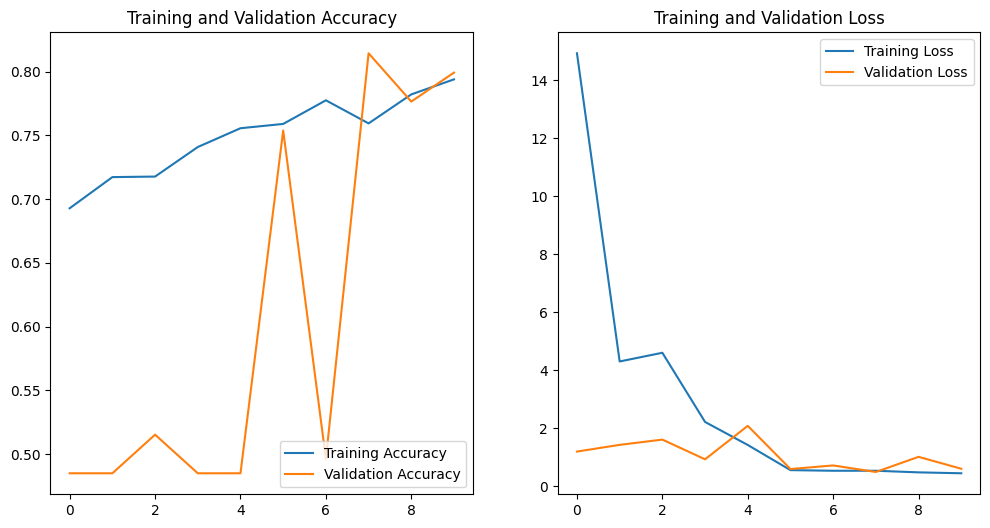

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


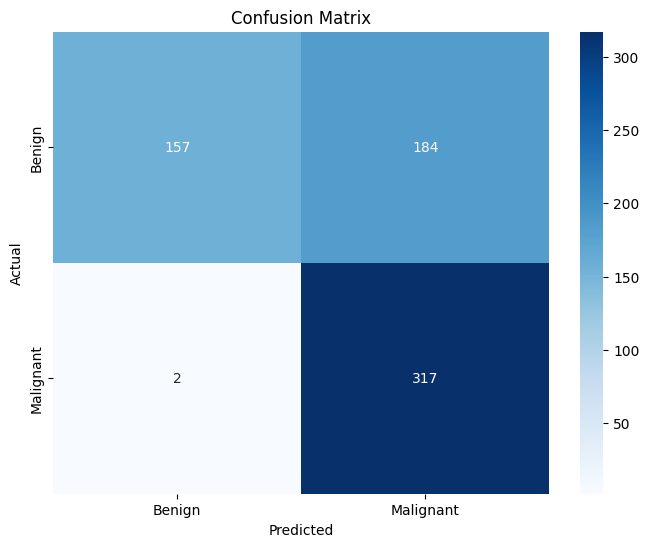

hello


In [ ]:
model_obj = ImageClassificationModel(optimizer='RMSprop', loss_function='categorical_crossentropy', activation_function='relu', output_activation_function='softmax', batch_size=32, epochs=10)

model_obj.run()

# Results

# Results

## 1
- 10 epochs
- loss: categorical_crossentropy
- Batch size: 64
- optimizer: RMSprop
- activation: relu (for all layers except output)

<br>
Test score: 2.2877860069274902<br>
Test accuracy: 0.7651515007019043

## 2
- 20 epochs
- loss: categorical_crossentropy
- Batch size: 64
- optimizer: RMSprop
- activation: relu (for all layers except output)

<br>
Test loss: 0.45444709062576294 <br>
Test accuracy: 0.831818163394928

## 3
- 30 epochs
- loss: categorical_crossentropy
- Batch size: 128
- optimizer: RMSprop
- activation: relu (for all layers except output)

<br>
Test loss: 1.4917829036712646 <br>
Test accuracy: 0.4848484992980957



**Introduced separate test and validation set after this point**

## 4
- 30 epochs
- loss: categorical_crossentropy
- Batch size: 128
- optimizer: RMSprop
- activation: relu (for all layers except output)

<br>
Test loss: 1.4917829036712646 <br>
Test accuracy: 0.4848484992980957


**Pre Processing Testing**

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Test loss: 0.6276654005050659
Test accuracy: 0.4636363685131073


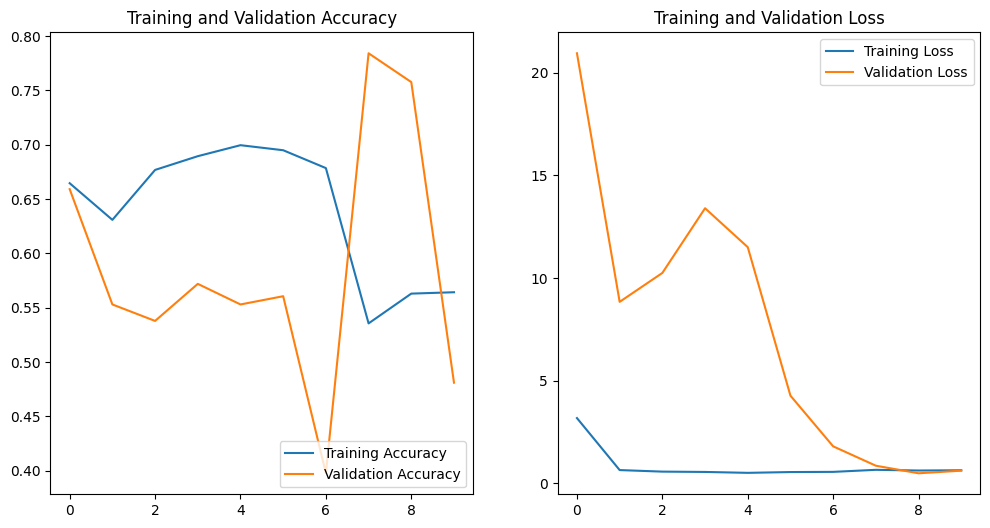

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


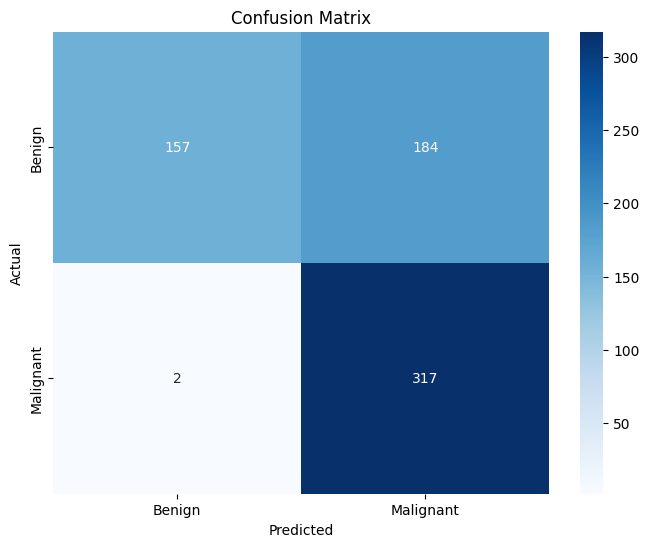

hello


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2
)

model_obj = ImageClassificationModel(
    optimizer='adam',
    loss_function='binary_crossentropy',
    activation_function='relu',
    output_activation_function='sigmoid',
    batch_size=32, epochs=10,
    data_augmentation=datagen)

model_obj.run()

#